In [45]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
from torchsummary import summary
warnings.filterwarnings('ignore')

# Device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [46]:
# first we built the architecture of LeNet5

# This convolution architecture was built majorly for classification of hand written digits MNIST dataset
# thus this model takes 32x32 gray scale input with single channel
# In LeNet5: 5 symbolizes the number of layers used i.e. 2 CONVOLUTION+MAXPOOL + 3 FULLY CONNECTED layers
# subsampling and increasing number of channels takes place as
# 32x32 -> 6 filters of 5x5 -> 28x28x5 -> 2x2 maxpool s=2 -> 14x14x5 -> 16 filters of 5x5 -> 10x10x16 -> 2x2 maxpool -> 5x5x16 ->flattens 400x1 -> 120x1 FC -> 84x1 FC -> 10
# image representation in pytorch tensor is Channel x Height x Width

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
batch_size = 64
num_classes = 10


In [49]:
# Building the architecture using nn.Module class

class LeNet5(nn.Module):
  # defining the initializer function with self and num_classes
  def __init__(self, num_classes):
    super(LeNet5, self).__init__() # inheritance
    # buiding 1st of the 5 layer architecture
    self.layer1 = nn.Sequential(
        nn.Conv2d( in_channels = 1, out_channels = 6 , kernel_size = (5,5), stride=(1,1), padding=(0,0)), # layer1
        nn.BatchNorm2d(6), # batchnorm for every channel
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d( in_channels = 6, out_channels = 16 , kernel_size = (5,5), stride = (1,1), padding = (0,0)), #layer2
        nn.BatchNorm2d(16), # batchnorm for every channel
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
    )

    self.fc1  = nn.Linear( 400, 120)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(120, 84)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output) # it dimension is 64 x 16 x 5 x 5 where 32 is the number of  examples in batches i.e. batch_size
    # print("output after layer2 ", output.size())
    output = output.reshape(output.size(0), -1) # reshapeing keeping the first dimenions intact and the rest -1 collapse i.e. 16x5x5 to 400
    output = self.fc1(output)
    output = self.relu1(output)
    output = self.fc2(output)
    output = self.relu2(output)
    output = self.fc3(output)
    return output

# no softmax output


Loading the Dataset

Using torchvision, we will load the dataset as this will allow us to perform pre-processing steps easily
The images are greyscale, all the size of 28x28 and is composed of 60k training images and 10k testing images


In [50]:
"""
keeping num_classes at 10, as this will be the output shape from the final laer of the LeNet5 Neural Network Model, because the output layer will have 10 output neurons, since the MNIST data
has 10 classes for each of the 10 numerical digits
"""
root_input_dataset_dir =  "/content/drive/My Drive/input_dataset"
train_dataset = torchvision.datasets.MNIST(root =root_input_dataset_dir, train =True, transform = transforms.Compose([
                                                                                                transforms.Resize((32,32)),
                                                                                                transforms.ToTensor(),
                                                                                                transforms.Normalize(mean = (0.1307 ,), std = (0.3081,))]), download = True)

test_dataset = torchvision.datasets.MNIST(root = root_input_dataset_dir, train = False, transform = transforms.Compose([
                                                                                                transforms.Resize((32,32)),
                                                                                                transforms.ToTensor(),
                                                                                                transforms.Normalize(mean = (0.1307,), std = (0.3081,)) ]), download= True)
 # to wrap iterator around the data to get large dataset to train without loading all of them at once in memory
train_dataloader = torch.utils.data.DataLoader(dataset= train_dataset, batch_size = batch_size , shuffle =True) # to wrap iterator around the data to get large dataset to train without loading all of them at once in memory
test_dataloader = torch.utils.data.DataLoader(dataset= test_dataset, batch_size = batch_size, shuffle = True)



In [51]:
learning_rate = 0.001

model = LeNet5(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

total_step = len(train_dataloader)



In [52]:
print('Length of the train dataloader ', len(train_dataloader))
print('Length of the test dataloader ', len(test_dataloader))

Length of the train dataloader  938
Length of the test dataloader  157


In [53]:
def train( model, criterion, optimizer , num_epochs =100):
  total_training_loss= []
  total_step = len(train_dataloader)

  for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels) # this returns a grad functions to get the actual loss loss.item() is used

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()*images.size(0) # updating the running_loss

      if (i+1)%400 ==0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    epoch_loss = running_loss/len(train_dataloader) # average loss per batch at each epoch
    total_training_loss.append(epoch_loss)
  return total_training_loss

In [35]:
total_training_loss = train(model, criterion, optimizer, num_epochs = 10)

Epoch [1/10], Step [400/938], Loss: 0.017316
Epoch [1/10], Step [800/938], Loss: 0.019030
Epoch [2/10], Step [400/938], Loss: 0.016919
Epoch [2/10], Step [800/938], Loss: 0.036647
Epoch [3/10], Step [400/938], Loss: 0.041569
Epoch [3/10], Step [800/938], Loss: 0.013333
Epoch [4/10], Step [400/938], Loss: 0.005225
Epoch [4/10], Step [800/938], Loss: 0.004217
Epoch [5/10], Step [400/938], Loss: 0.011155
Epoch [5/10], Step [800/938], Loss: 0.001773
Epoch [6/10], Step [400/938], Loss: 0.003998
Epoch [6/10], Step [800/938], Loss: 0.011854
Epoch [7/10], Step [400/938], Loss: 0.001124
Epoch [7/10], Step [800/938], Loss: 0.006924
Epoch [8/10], Step [400/938], Loss: 0.000267
Epoch [8/10], Step [800/938], Loss: 0.003883
Epoch [9/10], Step [400/938], Loss: 0.000860
Epoch [9/10], Step [800/938], Loss: 0.006941
Epoch [10/10], Step [400/938], Loss: 0.080106
Epoch [10/10], Step [800/938], Loss: 0.000336


In [36]:
total_training_loss

[3.3034611850309727,
 2.380640687909462,
 2.1091065371353457,
 1.7816763437901144,
 1.4190326899569083,
 1.312387179903019,
 1.1439066695646127,
 1.0305156224334775,
 0.8355491227270024,
 0.9521206656015658]

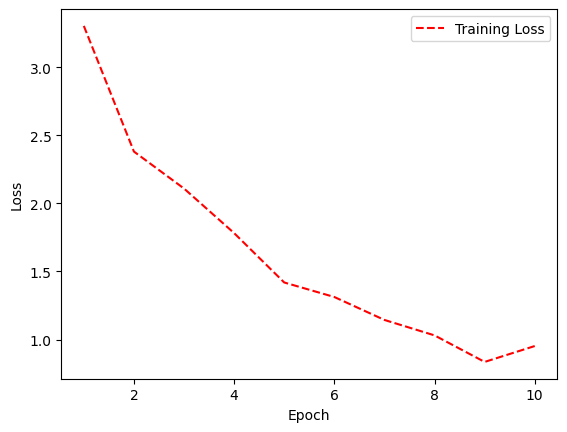

In [37]:
epoch_count = range( 1, len(total_training_loss)+1)

#visualise the loss history
plt.plot(epoch_count, total_training_loss, "r--")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [57]:
summary(model, input_size = (1, 32, 32), device = str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 61,750
Trainable params: 